In [22]:
import torch, os
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchvision import models
from collections import OrderedDict
from torch.utils import data
from PIL import Image
import pandas as pd
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [23]:
BATCH_SIZE = 32
EPOCHS = 20
NUM_WORKERS = 4
SPLIT_RATIO = 0.5
RANDOM_SEED = 123
CLASS_NUM = 200
ROOT = r'./CUB_200_2011'

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
class CUB():
    def __init__(self, root, dataset_type='train', train_ratio=1, valid_seed=123, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        print("checkpointCUB")
        df_img = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
        df_label = pd.read_csv(os.path.join(root, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
        df_split = pd.read_csv(os.path.join(root, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
        df = pd.concat([df_img, df_label, df_split], axis=1)
        # relabel
        df['Label'] = df['Label'] - 1
        print(train_ratio)
        # split data
        if dataset_type == 'test':
            df = df[df['Train'] == 0]
        elif dataset_type == 'train' or dataset_type == 'valid':
            df = df[df['Train'] == 1]
            # random split train, valid
            if train_ratio != 1:
                np.random.seed(valid_seed)
                indices = list(range(len(df)))
                np.random.shuffle(indices)
                split_idx = int(len(indices) * train_ratio) + 1
            elif dataset_type == 'valid':
                raise ValueError('train_ratio should be less than 1!')
            if dataset_type == 'train':
                df = df.iloc[indices[:split_idx]]
            else:       # dataset_type == 'valid'
                df = df.iloc[indices[split_idx:]]
        else:
            raise ValueError('Unsupported dataset_type!')
        self.img_name_list = df['Image'].tolist()
        self.label_list = df['Label'].tolist()
        # Convert greyscale images to RGB mode
        self._convert2rgb()

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.img_name_list[idx])
        image = Image.open(img_path)
        target = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def _convert2rgb(self):
        for i, img_name in enumerate(self.img_name_list):
            img_path = os.path.join(self.root, 'images', img_name)
            image = Image.open(img_path)
            color_mode = image.mode
            if color_mode != 'RGB':
                image = image.convert('RGB')
                image.save(img_path.replace('.jpg', '_rgb.jpg'))
                self.img_name_list[i] = img_name.replace('.jpg', '_rgb.jpg')

In [26]:
trans_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [27]:

train_data = CUB(ROOT, 'train', SPLIT_RATIO, RANDOM_SEED, transform=trans_train)
valid_data = CUB(ROOT, 'valid', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)


checkpointCUB
0.5
checkpointCUB
0.5


In [28]:
print("Train: {}".format(len(train_data)))
print("Valid: {}".format(len(valid_data)))

Train: 2998
Valid: 2996


In [29]:

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False)



In [30]:

model = models.googlenet(weights="DEFAULT")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")
model

Total number of parameters in the model: 6624904


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [31]:
# freeze layers
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
import torch.nn as nn

# Assuming `model` is your neural network instance

# Define your new fully connected layer
fc_layer = nn.Sequential(OrderedDict([
    ('fc0', nn.Linear(1024, 512)),
    ('norm0', nn.BatchNorm1d(512)),
    ('relu0', nn.ReLU(inplace=True)),
    ('fc1', nn.Linear(512, 200)),
]))

# Assign the new fully connected layer to the `fc` attribute
model.fc = fc_layer
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")


Total number of parameters in the model: 6228328


In [32]:
model.to(device)
import torch.nn.functional as F

# criterion = F.cross_entropy()


In [33]:
def accuracy(model, data_loader, N=None):
    test_correct = 0
    
    # number of samples
    if N == None:
        N = len(data_loader.dataset)
    
    # determine mode
    training = model.training
    if training:
        model.eval()
        
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            test_correct += (yhat == y).sum().item()
    test_acc = test_correct / N
    
    # switch back to former mode
    if training:
        model.train()

    return test_acc

In [34]:
costs, train_accs, test_accs = [], [], []

from torch import optim

In [35]:
# for x,y in train_loader:
#     z=model(x)
#     # print(y.shape)
#     # print(z)
#     break  # This will print the shape of each batch
# z[0]
# z[0].shape

In [36]:
def train(model, train_loader, test_loader, optimizer, scheduler, max_epoch=100, test_period=10):
    print("checkpoint1")
    N_train = len(train_loader.dataset)
    N_test = len(test_loader.dataset)
    best_acc = 0
    
    # make sure model is in the training mode
    model.train()

    for epoch in range(max_epoch):
        cost = 0
        correct = 0
        # print("checkpoint2")
        for x, y in train_loader:
            # setting GPU
            # print("checkpoint2.2")
            x, y = x.to(device), y.to(device)
            x.requires_grad = True 
            # print("checkpoint3")
            optimizer.zero_grad()
            z = model(x)
            loss = F.cross_entropy(z, y)
            print(loss)
            loss.backward()
            optimizer.step()
            # print("checkpoint4")

            cost += loss.item()
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            # # cyclic learning rate decay
            # costs.append(loss.item())
            # scheduler.step()
            # print("checkpoint5")

        # usual learning rate decay
        costs.append(cost/len(train_loader))
        # lrs.append(scheduler.get_last_lr())
        scheduler.step()
        # print("checkpoint4")
        # ! acc on train in train mode
        acc = correct / N_train
        print(acc)
        train_accs.append(acc)

        if epoch % test_period == 0:
            test_acc = accuracy(model, test_loader, N_test)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
            print("{:3d} cost: {:.4f}/ttrain_acc: {:.4f}/ttest_acc: {:.4f}".format(
                epoch, cost, acc, test_acc))

    # final test
    print('/nfinal accuracy')
    print('train: {:.3f}%/ttest: {:.3f}%/tbest on test: {:.3f}%'.format(acc*100, accuracy(model, test_loader)*100, best_acc*100))



In [37]:
# for x, y in train_loader:
#     # setting GPU
#     print(x,y)
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total number of training parameters in fine-tuned model: {num_params}")

Total number of training parameters in fine-tuned model: 628424


In [38]:
from matplotlib import pyplot as plt

def imshow(image, label, ax=None, normalize=True):
    """show single along with label on an ax"""
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """ show multiple samples

    args:
        nrows (int, optional): number of row
        ncols (int, optional): number of column
        title (str, optional): title.
        normalize (bool, optional): whether the images are normalized
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()

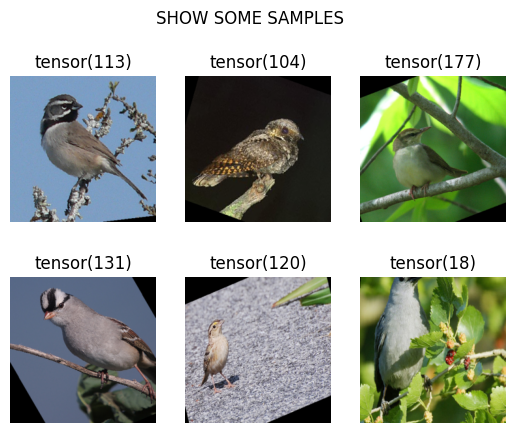

In [39]:
# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
images, labels = next(iter(train_loader))
show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME SAMPLES')

In [40]:
init_lr = 0.001
weight_decay = 1e-4
max_epoch = EPOCHS
test_period = 1

optimizer = optim.AdamW(model.fc.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
torch.save(model, "Tranfer_GN.pth")

checkpoint1
tensor(5.4104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.0071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.9580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.0131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.0972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.8873, device='cuda:

In [41]:
len(valid_loader)

47

In [51]:
t_accs = train_accs
for i in range(len(t_accs)):
    t_accs[i]=t_accs[i]*100
print(t_accs)

te_accs = test_accs
for i in range(len(te_accs)):
    te_accs[i]=te_accs[i]*100
print(te_accs)

cs_val = costs
for i in range(len(cs_val)):
    cs_val[i]=cs_val[i]
print(cs_val)


[12.775183455637091, 40.126751167444965, 52.568378919279546, 60.74049366244162, 66.91127418278853, 71.18078719146096, 75.81721147431621, 77.05136757838558, 80.4869913275517, 81.9212808539026, 84.82321547698464, 85.42361574382922, 87.62508338892594, 89.05937291527685, 89.62641761174116, 90.22681787858569, 90.76050700466978, 90.393595730487, 91.49432955303536, 91.16077384923283]
[25.634178905206944, 36.9826435246996, 42.590120160213615, 44.55941255006675, 46.128170894526036, 47.73030707610147, 48.63150867823765, 48.69826435246997, 49.06542056074766, 49.43257676902536, 49.69959946595461, 50.83444592790387, 50.53404539385847, 50.43391188251002, 50.033377837116156, 50.56742323097464, 50.467289719626166, 50.66755674232309, 50.20026702269692, 50.70093457943924]
[4.427430888657929, 2.748885106014949, 2.054196543590997, 1.6307224163445093, 1.3660867566703467, 1.1619020149271975, 0.9898071186516875, 0.9161493880774385, 0.8069643685894627, 0.7163753317248437, 0.6375959922549546, 0.605926311464719

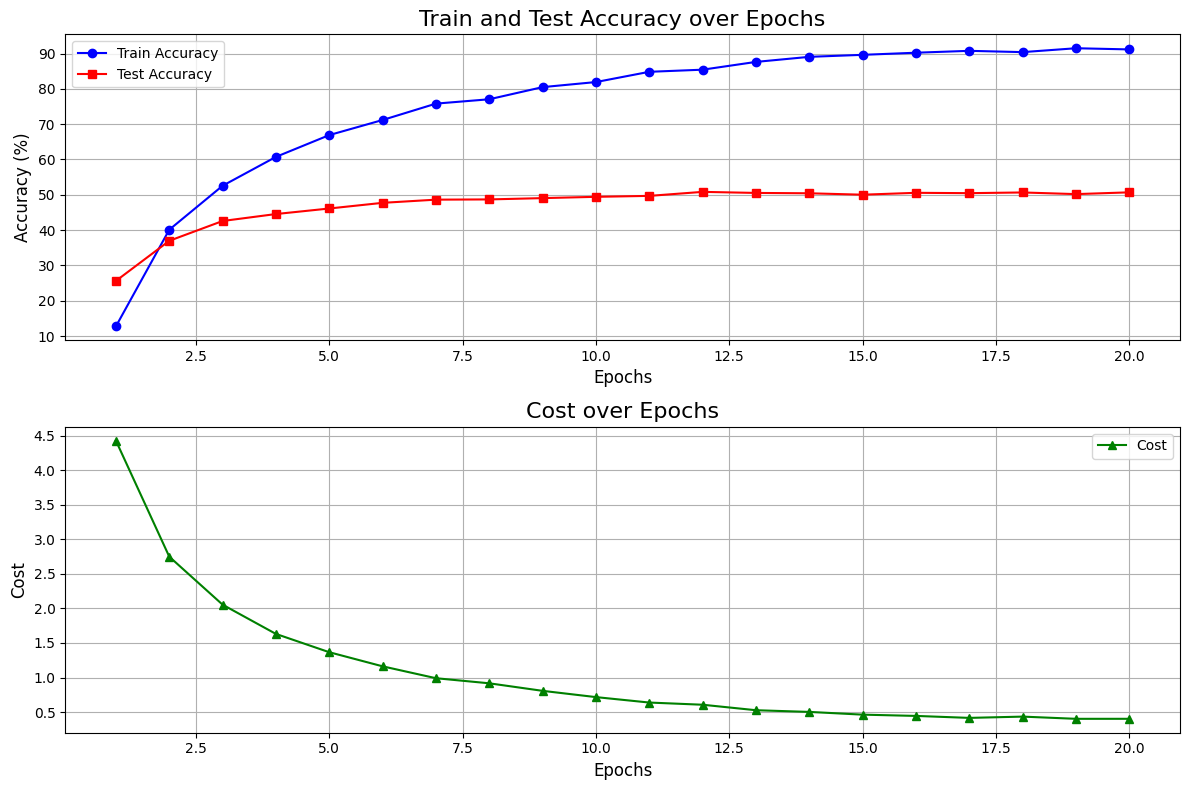

In [53]:
epochs = list(range(1, len(t_accs) + 1))

# Plotting
plt.figure(figsize=(12, 8))

# Plot for accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, t_accs, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, te_accs, label='Test Accuracy', color='red', marker='s')
plt.title('Train and Test Accuracy over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

# Plot for cost
plt.subplot(2, 1, 2)
plt.plot(epochs, cs_val, label='Cost', color='green', marker='^')
plt.title('Cost over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
tl_model = torch.load("Tranfer_GN.pth")
total_params = sum(p.numel() for p in tl_model.parameters())
print(f"Total number of parameters in the model: {total_params}")
tl_model

Total number of parameters in the model: 6228328


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track